<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Lecture 10: Spatial Networks</h2>
<h3>IT University of Copenhagen, Spring 2023</h3>
<h3>Instructor: Ane Rahbek Vierø</h3>
</div>

This notebook was adapted from:

* OSMnx examples: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/06-stats-indicators-centrality.ipynb
* Spaghetti: https://pysal.org/spaghetti/notebooks/network-spatial-dependence.html

In [1]:
import geopandas as gpd
import osmnx as ox
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib

import matplotlib.pyplot as plt

from scipy.spatial import Voronoi, voronoi_plot_2d

import spaghetti
import pandana

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
ox.__version__

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
/opt/conda/lib/python3.9/site-packages/esda/getisord.py:636: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if __name__ is "__main__":
/opt/conda/lib/python3.9/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


'1.1.2'

# Use OSMnx to calculate street network indicators

We will continue with OSMnx, building on last weeks lecture. OSMnx has build-in support for calculating core metrics for street networks (but consider using igraph or other alternatives for large networks).

First we download the Frederiksberg car network with OSMnx:

In [2]:
place = "Frederiksberg Municipality"
G = ox.graph_from_place(place, network_type="drive")
G_proj = ox.project_graph(G,to_crs="EPSG:25832")

## Calculate basic street network metrics (topological and geometric)

To get an initial description of our network, we calculate the [basic statistics](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=basic_stats#osmnx.stats.basic_stats).
In order to calculate density-based based, you must also pass the network's bounding area in square meters (otherwise basic_stats() will just skip them in the calculation):

In [3]:
# Calculate Frederiksberg's basic stats

city = ox.geocode_to_gdf(place)
city_proj = ox.project_gdf(city, to_crs="EPSG:25832")
area = city_proj.unary_union.area

print(f"The area of Frederiksberg is {area:.0f} square meters")

The area of Frederiksberg is 8710913 square meters


Notice how very few nodes has degree = 2 (`streets_per_node_counts`). This is because OSMnx simplifies the network by default - for a non-simplified OSM network, the share of degree 2 nodes would be much higher.

In [4]:
stats = ox.basic_stats(G, area=area) # Returns a nested dictionary
pd.Series(stats)

n                                                                             804
m                                                                            1918
k_avg                                                                    4.771144
edge_length_total                                                      184399.092
edge_length_avg                                                         96.141341
streets_per_node_avg                                                     2.893035
streets_per_node_counts         {0: 0, 1: 109, 2: 27, 3: 514, 4: 150, 5: 3, 6: 1}
streets_per_node_proportions    {0: 0.0, 1: 0.13557213930348258, 2: 0.03358208...
intersection_count                                                            695
street_length_total                                                    109472.567
street_segment_count                                                         1144
street_length_avg                                                       95.692803
circuity_avg    

Streets/intersection counts and proportions are nested dicts inside the stats dict. To convert these stats to a pandas dataframe (to compare/analyze multiple networks against each other), just unpack these nested dicts first:

In [5]:
# unpack dicts into individiual keys:values
stats = ox.basic_stats(G, area=area)
for k, count in stats["streets_per_node_counts"].items():
    stats["{}way_int_count".format(k)] = count
for k, proportion in stats["streets_per_node_proportions"].items():
    stats["{}way_int_prop".format(k)] = proportion

# delete the no longer needed dict elements
del stats["streets_per_node_counts"]
del stats["streets_per_node_proportions"]

# load as a pandas dataframe
pd.DataFrame(pd.Series(stats, name="value")).round(3)

,value
n,804.000
m,1918.000
k_avg,4.771
edge_length_total,184399.092
edge_length_avg,96.141
streets_per_node_avg,2.893
intersection_count,695.000
street_length_total,109472.567
street_segment_count,1144.000
street_length_avg,95.693


### Betweenness centrality

Betweenness centrality is based on how many times a link/edges is part of all shortest paths in the network, when calculating the shortest paths from all node pair combinations ('All Pair Shortest Paths'):

$$g(ij) = \sum_{s,t}{\sigma_{st}(ij) \over σ_{st}}$$

Our calculation of betweenness centrality is slightly faster if we use a [digraph](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=get_digraph#osmnx.utils_graph.get_digraph) - i.e. a network with no parallel edges and where only the shortest edge between the same node pair is kept. Since our shortest paths are based on the edge length, the longer parallel edge will anyway never be part of a path (but this only holds as long as we only base our shortest path compuation on edge length!)

We use NetworkX to calculate the betweenness. OSMnx is build on top of [NetworkX](https://networkx.org/documentation/stable/index.html) and we can thus seamlessly work with all Networkx functions.

In [6]:
# calculate betweenness with an undirected graph (ie, no parallel edges)
bc = nx.betweenness_centrality(ox.get_digraph(G_proj), weight="length")
max_node, max_bc = max(bc.items(), key=lambda x: x[1])
max_node, max_bc

(576734, 0.24822750098601565)

In Frederiksberg Municipality, the node with the highest betweenness centrality has ~25% of all shortest paths running through it. Let's highlight it in the plot:

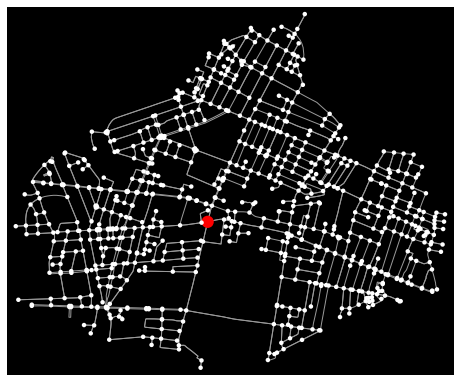

In [7]:
nc = ["r" if node == max_node else "w" for node in G.nodes]
ns = [150 if node == max_node else 20 for node in G.nodes]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2, bgcolor="k")

Let's look at the relative betweenness centrality of every node in the graph:

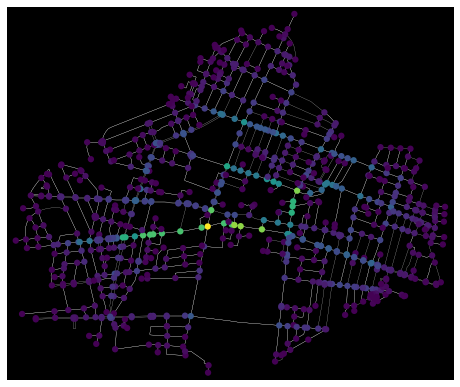

In [8]:
# add the betweenness centrality values as new node attributes, then plot
nx.set_node_attributes(G_proj, bc, "bc") # We set the betweenness centrality as a new attributes
nc = ox.plot.get_node_colors_by_attr(G_proj, "bc", cmap="viridis") # get node color based on attribute

ox.plot_graph(
    G_proj,
    node_color=nc,
    node_size=40,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
    bgcolor="k",
);


Above, the nodes are visualized by betweenness centrality, from low (dark violet) to high (light yellow). The colors in the colorspace are linearly mapped to the attribute values (i.e. not classified).

We can calculate a range of other **centrality** metrics with NetworkX: https://networkx.org/documentation/stable/reference/algorithms/centrality.html.

# Pandana

"[Pandana](https://udst.github.io/pandana/index.html) is a Python library for network analysis that uses contraction hierarchies to calculate super-fast travel accessibility metrics and shortest paths. The numerical code is in C++."

Pandana is especially good for analyzing accessibility across large networks. In this terms accessibility broadly defines to what extent you can reach a given type of amenity or destination from different parts of the network.

Pandana uses a slightly different syntax than e.g. OSMnx, but the core idea of modelling a network with edge and node dataframes is the same.

For a quick intro to what Pandana can be used for, let's see how far you need to bike to reach a metro station from any node in Frederiksberg.


In [9]:
# Get bike network from OSM
G_bike = ox.graph_from_place('Frederiksberg Municipality', network_type='bike', retain_all=False)

Because we will use our network to compute accessibility to public transport within a given time frame, we need to set the travel speed on our edges:

In [10]:
# Convert to pandana network
# For this we first need the nodes and edges as geodataframes

G_bike_proj = ox.project_graph(G_bike, to_crs='EPSG:25832') # project to get correct distances

nodes = ox.graph_to_gdfs(G_bike_proj, edges=False)[['x', 'y']]
edges = ox.graph_to_gdfs(G_bike_proj, nodes=False).reset_index()

edges['length'] = edges.length
edges = edges[['u','v','length']] # throw away unnecessary columns

network = pandana.Network(node_x=nodes['x'],
                          node_y=nodes['y'], 
                          edge_from=edges['u'],
                          edge_to=edges['v'],
                          edge_weights=edges[['length']]) # we specify that we are interested in the length - but this could also be travel time, cost or something else

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 3805
Setting CH edge vector of size 8212
Range graph removed 7562 edges of 16424
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

In [11]:
# Get all the public transport stops     
tags = {'station':'subway','network':'metro'}
transit = ox.geometries_from_place('Frederiksberg Municipality', tags=tags)

transit = transit.drop_duplicates('name') # avoid duplicates, e.g. when each level/platform of a station is tagged separately

transit = transit.to_crs('EPSG:25832')

transit.head()

name network public_transport  railway  \
element_type osmid                                                              
node         1271230723           Lindevang   Metro          station  station   
             1724493427  Frederiksberg Allé   Metro    stop_position     stop   
             5072901609           Flintholm     NaN          station  station   
             5715956180               Forum     NaN          station  station   
             5715956181       Frederiksberg   Metro          station  station   

                        station subway wheelchair wikidata  \
element_type osmid                                           
node         1271230723  subway    yes        yes  Q801103   
             1724493427  subway    yes        NaN      NaN   
             5072901609  subway    yes        yes      NaN   
             5715956180  subway    yes        NaN  Q800764   
             5715956181  subway    yes        yes      NaN   

                                               geometry level  
element_type osmid                                             
node         1271230723  POINT (720846.861 6176444.313)   NaN  
             1724493427  POINT (722621.854 6175423.918)   NaN  
             5072901609  POINT (719972.646 6176670.536)   NaN  
             5715956180  POINT (723329.010 6176387.859)    -2  
             5715956181  POINT (722055.990 6176251.698)   NaN

In [12]:
# Let's index on the station name so we can identify them later and get rid of unnecessary cols
transit = transit.set_index('name')[['geometry']]

# Some stations might be polygons, but we need them as points, so let's extract the centroids from the geometries
transit.geometry = transit.centroid


In [14]:
# set the amenities' locations on the network 
network.set_pois(category='metro',
                 maxdist=3000, # Max distance we will bike
                 maxitems=1, # we are just looking for the one closest station
                 x_col=transit.geometry.x, 
                 y_col=transit.geometry.y)

/opt/conda/lib/python3.9/site-packages/pandana/network.py:660: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/opt/conda/lib/python3.9/site-packages/pandana/network.py:668: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


In [15]:
# calculate travel time to nearest metro station from each node in network
distances = network.nearest_pois(distance=3000,
                                 category='metro',
                                 num_pois=1,
                                include_poi_ids=True)

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


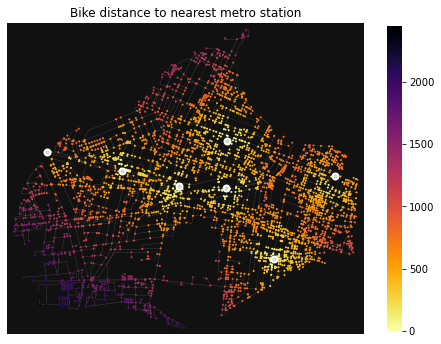

In [16]:
# Plot distance to nearest metro station from each node
fig, ax = ox.plot_graph(G_bike_proj, node_size=0, edge_linewidth=0.1,
                        edge_color='gray', show=False, close=False)

sc = ax.scatter(x=nodes['x'],
                y=nodes['y'], 
                c=distances[1],
                s=1,
                cmap='inferno_r')

# plot stations to sanity check our computations
transit.plot(ax=ax, color='#CBDCCB', edgecolor='white', linewidth=2)

ax.set_title('Bike distance to nearest metro station')
plt.colorbar(sc, shrink=0.7).outline.set_edgecolor('none')

This is just an example - actually the locations in Frb with the furthest distance to a metro station might have a Copenhagen station much closer.
This **edge effect** is generally something to be cautious of when doing spatial network analysis!

# Voronoi diagram

Let's try creating a the Voronoi diagram using [scipy.spatial](https://docs.scipy.org/doc/scipy/reference/spatial.html).

Voronoi diagrams can for example be used to tell us, what the closest pharmacy to any location is in Frederiksberg?

In [17]:
# First fetch all pharmacies and project them
tags = {'amenity': ['pharmacy']}
gdf_pharmacies = ox.geometries_from_place(place, tags=tags)
gdf_pharmacies = ox.project_gdf(gdf_pharmacies, to_crs='EPSG:25832')
gdf_pharmacies

/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


amenity healthcare                       name  \
element_type osmid                                                        
node         2955867754  pharmacy   pharmacy    Dalgas Boulevard Apotek   
             4886221183  pharmacy   pharmacy           Apoteket Godthåb   
             6579860143  pharmacy   pharmacy         Smallegades Apotek   
             6959994877  pharmacy   pharmacy                   Apoteket   
             7144688116  pharmacy        NaN              Apotek Ørsted   
             8254386587  pharmacy   pharmacy         Apotek Borups Allé   
             8367053969  pharmacy   pharmacy  Frederiksberg Løve Apotek   
             9089831028  pharmacy        NaN       Frederiksberg Apotek   

                                                             opening_hours  \
element_type osmid                                                           
node         2955867754  Mo-Th 09:00-17:30; Fr 09:00-18:00; Sa 09:30-13:30   
             4886221183                  Mo-Fr 09:00-19:00; Sa 09:30-16:00   
             6579860143  08:00-17:30; Sa 09:00-13:30; Su off; Jan 1 off...   
             6959994877                                                NaN   
             7144688116                                  Mo-Su 08:00-20:00   
             8254386587                                        08:00-20:00   
             8367053969  Mo-We 09:30-18:00; Th-Fr 10:00-18:00; Sa 09:30...   
             9089831028                                                NaN   

                        toilets:wheelchair  \
element_type osmid                           
node         2955867754                 no   
             4886221183                NaN   
             6579860143                NaN   
             6959994877                NaN   
             7144688116                NaN   
             8254386587                NaN   
             8367053969                NaN   
             9089831028                NaN   

                                                                   website  \
element_type osmid                                                           
node         2955867754  https://www.apoteket.dk/apoteker/frederiksberg...   
             4886221183                                                NaN   
             6579860143                  https://smallegade.apotekeren.dk/   
             6959994877                                                NaN   
             7144688116                                                NaN   
             8254386587                                                NaN   
             8367053969                                                NaN   
             9089831028                    https://frederiksbergapotek.dk/   

                        wheelchair                        geometry  \
element_type osmid                                                   
node         2955867754        yes  POINT (720697.077 6176239.575)   
             4886221183        NaN  POINT (722400.380 6176758.996)   
             6579860143        yes  POINT (721524.812 6176059.627)   
             6959994877        NaN  POINT (722012.208 6176269.805)   
             7144688116        NaN  POINT (723096.202 6176184.239)   
             8254386587        NaN  POINT (722051.163 6177647.834)   
             8367053969        yes  POINT (722463.758 6176750.492)   
             9089831028        NaN  POINT (722311.388 6175895.515)   

                                              fvst:name fvst:navnelbnr  \
element_type osmid                                                       
node         2955867754                             NaN            NaN   
             4886221183  Frederiksberg Apoteket Godthåb         905864   
             6579860143                             NaN         519499   
             6959994877                             NaN            NaN   
             7144688116                             NaN         909881   
             8254386587          

In [18]:
# Let's extract the coordinates
pharmacies_coords = list(zip(gdf_pharmacies.geometry.x.values, gdf_pharmacies.geometry.y.values))
pharmacies_coords

[(720697.0768210063, 6176239.575206408),
 (722400.3803508678, 6176758.995880257),
 (721524.8120071017, 6176059.627099156),
 (722012.2077366732, 6176269.804738003),
 (723096.2015666275, 6176184.238980024),
 (722051.162912226, 6177647.834499951),
 (722463.7578274995, 6176750.491565414),
 (722311.3884982386, 6175895.514773406)]

## Voronoi diagram for pharmacies in Frb

/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


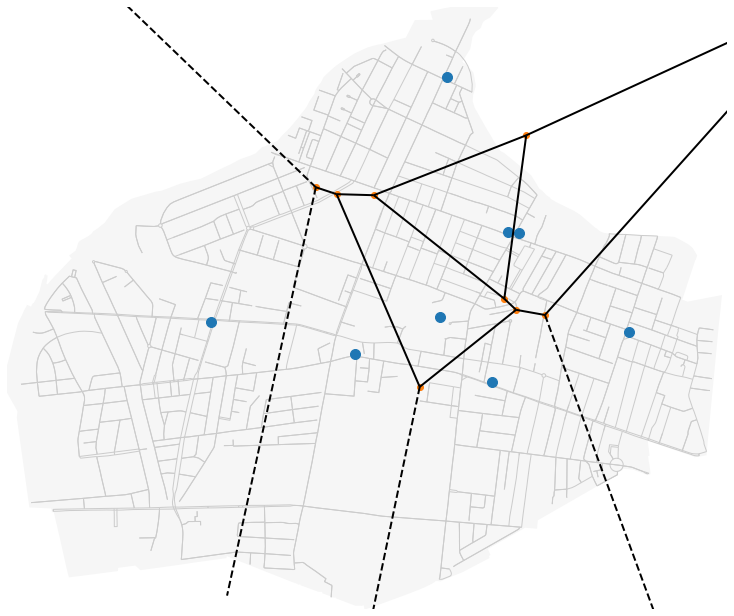

In [19]:
vor = Voronoi(pharmacies_coords)
fig = plt.figure(figsize=(10,10))
axes = fig.add_axes([0, 0, 1, 1])
voronoi_plot_2d(vor, ax=axes, line_width = 2, point_size=20);

# Plot city border
city_proj.plot(fc="#F6F6F6", ec="none", ax=axes);

# Plot street network
ox.plot_graph(G_proj, node_size=0, bgcolor="w", ax=axes, edge_color="#CCCCCC");

Voila! The thick black lines defines the areas closest to each pharmacy (blue).

# Network-constrained spatial analysis with Spaghetti

Spatial networks are used extensively in the study of urban form, routing etc., but sometimes we also 'just' want to use the networks for a more accurate modelling of distances and connections.
For example, many of our previous analysis of spatial autocorrelation, clustering etc. only looked at the Euclidian distance ('as the crow flies') - which can be very different from the actual distance for those travelling on the street network.

For those purposes, [spaghetti](https://pysal.org/spaghetti/index.html), part of the PySAL family, is great because it allows us to constrain spatial dependence to the spatial network: [example1](https://pysal.org/spaghetti/notebooks/network-spatial-dependence.html) [example2](https://github.com/pysal/spaghetti/blob/main/notebooks/network-spatial-autocorrelation.ipynb).

## Clustering with Ripley's K
Ripley's K function takes a point pattern and considers all pairwise distances of nearest neighbors to determine the existence of clustering, or lack thereof, over a delineated range of distances based on what we would expect from a random point pattern. See [Wiki explanation](https://en.wikipedia.org/wiki/Spatial_descriptive_statistics#Ripley) or an [introduction to point pattern detection with Ripley](https://geographicdata.science/book/notebooks/08_point_pattern_analysis.html#ripley-s-alphabet-of-functions).

However, using a regular Ripley's K for urban amenities is wrong: Amenities cannot be reached as the crow flies - you can't move through buildings, so we need to consider the distances when we travel on the street network. We can for example use this to answer questions such as "how clustered are pubs/pharmacies *on the street network*?"

We want to analyze two point of interest (POI) datasets in Frederiksberg: 1) Pubs+Restaurants, and 2) Pharmacies (from above). Let's fetch and project the new dataset, pubs+restaurants (pharmacies were downloaded above):

In [20]:
tags = {'amenity': ['pub', 'restaurant']}
gdf_pubs = ox.geometries_from_place(place, tags=tags)
gdf_pubs = ox.project_gdf(gdf_pubs, to_crs="EPSG:25832")
gdf_pubs

/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


amenity fvst:navnelbnr                      name  \
element_type osmid                                                              
node         277694702           pub         115321               Cafe Intime   
             277703258           pub         111210                Alléenberg   
             278380921           pub         921122                Cafe Svejk   
             278389273           pub         738934                Promenaden   
             279143638    restaurant         115050              Viet Nam Nam   
...                              ...            ...                       ...   
             9217106974   restaurant        1111573            Bjørnekælderen   
             9280775697   restaurant        1144806                   Circolo   
             9630212016   restaurant         706630  Madklubben frederiksberg   
             10738149718  restaurant         983119       Hanzo Frederiksberg   
             10738149723  restaurant        1239025                     Mamak   

                                                              opening_hours  \
element_type osmid                                                            
node         277694702                                  Mo-Su 16:00 - 02:00   
             277703258                                    Tu-Sa 22:00-05:00   
             278380921                  Su-Mo 12:00-24:00;Tu-Sa 12:00-02:00   
             278389273    Mo-We 11:00-23:00; Th-Sa 11:00-24:00; Su 11:00...   
             279143638                                          16:00-23:00   
...                                                                     ...   
             9217106974                              11:30-23:00; Su-Tu off   
             9280775697   17:30-24:00;Sa 11:30-15:30,17:30-24:00;Su 11:3...   
             9630212016   11:30-15:30,17:00-24:00; Su-Mo 11:30-15:30,17:...   
             10738149718  10:00-17:00; Fr 10:00-20:00; Sa 12:00-20:00; S...   
             10738149723                                                NaN   

                                    phone ref:DK:cvr ref:DK:cvr:pnummer  \
element_type osmid                                                        
node         277694702    +45 38 34 19 58   27979440         1010696328   
             277703258       +45 33254442   25689097         1007991440   
             278380921       +45 38862560   40692932         1024914271   
             278389273                NaN   39126680         1023555944   
             279143638                NaN   54395957         1014630240   
...                                   ...        ...                ...   
             9217106974      +45 47477747   42518824         1027322286   
             9280775697      +45 51302120   42228567         1026929578   
             9630212016      +45 38414170   38554697         1022346209   
             10738149718     +45 38423477   42159743         1026846427   
             10738149723     +45 30116661   42905070         1027825571   

                         toilets  \
element_type osmid                 
node         277694702       yes   
             277703258       yes   
             278380921       NaN   
             278389273       NaN   
             279143638       NaN   
...                          ...   
             9217106974      NaN   
             9280775697      NaN   
             9630212016      NaN   
             10738149718     NaN   
             10738149723     NaN   

                                                                    website  \
element_type osmid                                                            
node         277694702                            http://www.cafeintime.dk/   
             277703258                            http://www.alleenberg.dk/   
             278380921                                                  NaN   
             278389273                                                  NaN   
             279143638      

In [ ]:
fig = plt.figure(figsize=(12, 9))
axes = fig.add_axes([0, 0, 1, 1])

# Plot city border
city_proj.plot(fc="#F6F6F6", ec="none", ax=axes);

# Plot the two POI datasets
gdf_pubs.plot(ax=axes, color="r", markersize=60, marker="s")
gdf_pharmacies.plot(ax=axes, color="b", markersize=120)

# Plot street network
ox.plot_graph(G_proj, node_size=0, bgcolor="w", ax=axes);

We first need a helper function for nice plotting (adapted from https://pysal.org/spaghetti/notebooks/network-spatial-dependence.html#Results-plotting-helper-function)

In [ ]:
def plot_k(k, _arcs, df1, df2, obs, wr=[1, 1.2], size=(14, 7)):
    """Plot a Global Auto K-function and spatial context."""
    def function_plot(f, ax):
        """Plot a Global Auto K-function."""
        ax.plot(k.xaxis, k.observed, "b-", linewidth=1.5, label="Observed")
        ax.plot(k.xaxis, k.upperenvelope, "r--", label="Upper")
        ax.plot(k.xaxis, k.lowerenvelope, "k--", label="Lower")
        ax.legend(loc="best", fontsize="x-large")
        title_text = "Global Auto $K$ Function: %s\n" % obs
        title_text += "%s steps, %s permutations," % (k.nsteps, k.permutations)
        title_text += " %s distribution" % k.distribution
        f.suptitle(title_text, fontsize=25, y=1.1)
        ax.set_xlabel("Distance $(r)$", fontsize="x-large")
        ax.set_ylabel("$K(r)$", fontsize="x-large")

    def spatial_plot(ax):
        """Plot spatial context."""
        base = _arcs.plot(ax=ax, color="k", alpha=0.25)
        df1.plot(ax=base, color="g", markersize=30, alpha=0.25)
        df2.plot(ax=base, color="g", marker="x", markersize=100, alpha=0.5)

    sub_args = {"gridspec_kw":{"width_ratios": wr}, "figsize":size}
    fig, arr = matplotlib.pyplot.subplots(1, 2, **sub_args)
    function_plot(fig, arr[0])
    spatial_plot(arr[1])
    fig.tight_layout()



Because spaghetti has no OSMnx integration, we need to input data in a different format - for example by convertin the graph to a GeoDataframe with the edges:

In [ ]:
ntw = spaghetti.Network(in_data=ox.graph_to_gdfs(G_proj,nodes=False)) # Create spaghetti network

# Create geodataframes with nodes and edges - which spaghetti usually refers to as vertices and arcs!
vertices_df, arcs_df = spaghetti.element_as_gdf(
    ntw, vertices=ntw.vertex_coords, arcs=ntw.arcs
)

Snap pubs and pharmacies to our street network, creating two pointpatterns on the network:

In [ ]:
ntw.snapobservations(gdf_pubs, "pubs", attribute=True)
ntw.snapobservations(gdf_pharmacies, "pharmacies", attribute=True)
ntw.pointpatterns

Save the pointpatterns and their snapped versions as gdfs for plotting:

In [ ]:
pubs = spaghetti.element_as_gdf(ntw, pp_name="pubs")
pubs_snapped = spaghetti.element_as_gdf(ntw, pp_name="pubs", snapped=True)
pharmacies = spaghetti.element_as_gdf(ntw, pp_name="pharmacies")
pharmacies_snapped = spaghetti.element_as_gdf(ntw, pp_name="pharmacies", snapped=True)

## Clustering of pubs and restaurants

Running Ripley's K for pubs *on the network* (this can take around 2 minutes):

In [ ]:
np.random.seed(0)
kres = ntw.GlobalAutoK(
    ntw.pointpatterns["pubs"],
    nsteps=10, # The number of steps at which the count of the nearest neighbors is computed.
    permutations=99) # Keep permutations low here, otherwise it will take too much time for computation
plot_k(kres, arcs_df, pubs, pubs_snapped, "pubs")

### Interpretation

The 'upper' and 'lower' curves defines the expected value of Ripley's K for a random point pattern. Because the *observed* curve always is above the simulation envelope, we can conclude that pubs+restaurants are clustered on the street network **on all scales**. 

This looks like an example for economies of agglomeration or business cluster effects, especially Gammel Kongevej and Pile Alle/Falkoner Alle:  
https://en.wikipedia.org/wiki/Economies_of_agglomeration https://en.wikipedia.org/wiki/Business_cluster#Cluster_effect

## Clustering of pharmacies

Now let's run Ripley's K on the pharmacies. This is much faster due to the low number of points, so we can crank up the parameters:

In [ ]:
np.random.seed(0)
kres = ntw.GlobalAutoK(
    ntw.pointpatterns["pharmacies"],
    nsteps=100,
    permutations=999)
plot_k(kres, arcs_df, pharmacies, pharmacies_snapped, "pharmacies")

### Interpretation

Pharmacies show different clustering behavior than pubs+restaurants. If it wasn't for those two pharmacies in the north east right next to each other, their observed curve would be on the lowest end of the simulation envelope for low distances, showing that they are quite dispersed on short ranges. Maybe there are minimum distance laws in place to make pharmacies cover the city well? On the other hand, for distances above 2km, the observed curve is above the envelope, meaning clustering. On this scale, pharmacies are clustered in the east, and there is quite some empty space in the north west and south west of Frederiksberg.